# Обработка видео
Классификация действий по видео


In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 9.0 MB/s 


## Загрузка и распаковка датасета KTH

In [3]:
# Подключаемся к диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Разархивирование файлов
if 1:
    !unzip '/content/drive/MyDrive/KHT/walking.zip' -d '/content/drive/MyDrive/KHT/unpack'
    !unzip '/content/drive/MyDrive/KHT/jogging.zip' -d '/content/drive/MyDrive/KHT/unpack'

Archive:  /content/drive/MyDrive/KHT/walking.zip
  inflating: /content/drive/MyDrive/KHT/unpack/person01_walking_d1_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person01_walking_d2_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person01_walking_d3_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person01_walking_d4_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person02_walking_d1_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person02_walking_d2_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person02_walking_d3_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person02_walking_d4_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person03_walking_d1_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person03_walking_d2_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person03_walking_d3_uncomp.avi  
  inflating: /content/drive/MyDrive/KHT/unpack/person03_walking_d4_unco

## Подготовка датасета для классификации

In [21]:
data_root = '/content/drive/MyDrive/KHT/unpack/'

In [18]:
from os import walk
filenames = next(walk('/content/drive/MyDrive/KHT/unpack/'), (None, None, []))[2]  # [] if no file
filenames[:3]

['person01_walking_d1_uncomp.avi',
 'person01_walking_d2_uncomp.avi',
 'person01_walking_d3_uncomp.avi']

In [23]:
data_root+filenames[0]

'/content/drive/MyDrive/KHT/unpack/person01_walking_d1_uncomp.avi'

In [24]:
classes = ['walking', 'jogging']

dataset = []

for file in filenames:
    if 'walking' in file:
        cls_idx = classes.index('walking')
        fpath = data_root+file
        dataset.append((fpath, cls_idx))
    elif 'jogging' in file:
        cls_idx = classes.index('jogging')
        fpath = data_root+file
        dataset.append((fpath, cls_idx))
    else:
      pass

In [25]:
dataset[:5]

[('/content/drive/MyDrive/KHT/unpack/person01_walking_d1_uncomp.avi', 0),
 ('/content/drive/MyDrive/KHT/unpack/person01_walking_d2_uncomp.avi', 0),
 ('/content/drive/MyDrive/KHT/unpack/person01_walking_d3_uncomp.avi', 0),
 ('/content/drive/MyDrive/KHT/unpack/person01_walking_d4_uncomp.avi', 0),
 ('/content/drive/MyDrive/KHT/unpack/person02_walking_d1_uncomp.avi', 0)]

In [26]:
TRAIN_LEN = 180
TEST_LEN = 30
random.shuffle(dataset)
train = dataset[:TRAIN_LEN]
test = dataset[TRAIN_LEN: (TRAIN_LEN + TEST_LEN)]

print('Train samples (subset):', len(train))
print('Test samples (subset):', len(test))

Train samples (subset): 180
Test samples (subset): 20


In [27]:
train[:5]

[('/content/drive/MyDrive/KHT/unpack/person11_jogging_d4_uncomp.avi', 1),
 ('/content/drive/MyDrive/KHT/unpack/person20_jogging_d2_uncomp.avi', 1),
 ('/content/drive/MyDrive/KHT/unpack/person16_walking_d2_uncomp.avi', 0),
 ('/content/drive/MyDrive/KHT/unpack/person07_jogging_d4_uncomp.avi', 1),
 ('/content/drive/MyDrive/KHT/unpack/person15_walking_d2_uncomp.avi', 0)]

In [28]:
train_shapes = []
for i in range(len(train)):
    videodata = skvideo.io.vread(train[i][0])
    train_shapes.append(videodata.shape)

In [29]:
train_shapes = sorted(train_shapes)
train_shapes[0], train_shapes[-1]

((284, 120, 160, 3), (1120, 120, 160, 3))

In [30]:
test_shapes = []
for i in range(len(test)):
    videodata = skvideo.io.vread(test[i][0])
    test_shapes.append(videodata.shape)

In [31]:
test_shapes = sorted(test_shapes)
test_shapes[0], test_shapes[-1]

((312, 120, 160, 3), (1065, 120, 160, 3))

## Визуализация кадра из видео

videodata shape: (390, 120, 160, 3)


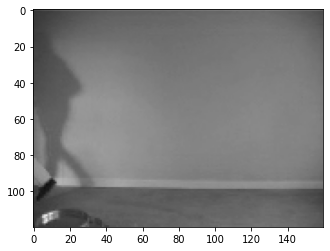

In [47]:
videodata = skvideo.io.vread(train[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (389, 120, 160, 1)


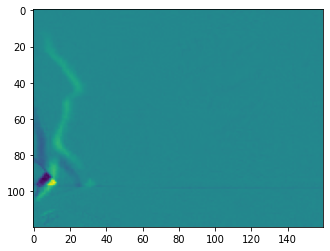

In [33]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

##Создание пайплайна данных

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [49]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 389, 120, 160, 1)
Output shape: (1, 6)


In [50]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [51]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/200] Loss = 1.7948884963989258
[0/10][10/200] Loss = 2.3858847618103027
[0/10][20/200] Loss = 0.6691378355026245
[0/10][30/200] Loss = 1.2288258075714111
[0/10][40/200] Loss = 0.5246358513832092
[0/10][50/200] Loss = 0.4076758921146393
[0/10][60/200] Loss = 0.5657392144203186
[0/10][70/200] Loss = 0.6599241495132446
[0/10][80/200] Loss = 0.5182915329933167
[0/10][90/200] Loss = 1.0657811164855957
[0/10][100/200] Loss = 0.8860957622528076
[0/10][110/200] Loss = 0.5881421566009521
[0/10][120/200] Loss = 0.5373673439025879
[0/10][130/200] Loss = 0.8219110369682312
[0/10][140/200] Loss = 0.6935838460922241
[0/10][150/200] Loss = 0.6650739908218384
[0/10][160/200] Loss = 0.6590936779975891
[0/10][170/200] Loss = 0.6590419411659241
[0/10][180/200] Loss = 0.6213410496711731
[0/10][190/200] Loss = 0.7215074300765991
[1/10][0/200] Loss = 0.8735780119895935
[1/10][10/200] Loss = 0.7746004462242126
[1/10][20/200] Loss = 1.0375847816467285
[1/10][30/200] Loss = 1.0568004846572876
[1/10][4

In [52]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

**Тестирование обученной модели**

True class: walking
Predicted class: walking


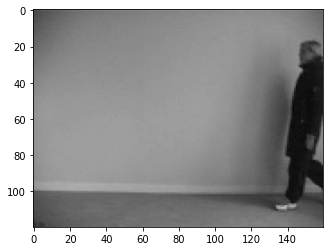

In [53]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])